# Quant GAN
## Torch Verison
[Wiese et al., Quant GANs: Deep Generation of Financial Time Series, 2019](https://arxiv.org/abs/1907.06673)

In [9]:
#%%capture
import os, sys
# file_name = 'ShanghaiSE_daily'  # 'ShanghaiSE_daily' or 'SP500_daily'
# colab = 'COLAB_GPU' in os.environ
# file_path = f'./data/{file_name}.csv'
# generator_path = f'./trained/'
# if colab:
# 	from google.colab import files
# 	!pip install torch
# 	file_path = f'/content/temporalCN/data/{file_name}.csv'
generator_path = f'/content/temporalCN/trained/'
	# username = "JamesSullivan"
	# repository = "temporalCN"
# 	!git clone https://github.com/{username}/{repository}.git
# 	sys.path.append('/content/temporalCN/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from preprocess.acf import *
from preprocess.gaussianize import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.torch_tcn import *


In [112]:
#retrieve and store ticker data
def get_data(tickers):
    #storing ticker in dictionary for convenience 
    ticker_data ={}
    start_date = "1999-06-01"
    end_date = "2019-06-01"
    
    #iterating through ticker list
    for ticker in tickers:
        ticker_object = yf.Ticker(ticker)
        historical_data = ticker_object.history(start=start_date, end=end_date, interval="1d")
        ticker_data[str(ticker)] = historical_data['Close']
        
    return ticker_data

In [151]:
#test
tickers = ['AAPL', 'SPY']
data = get_data(tickers)

In [152]:
#change type to df for extraction (and convenience) in a new cell so don't have to download data each time
data = pd.DataFrame(data=data)

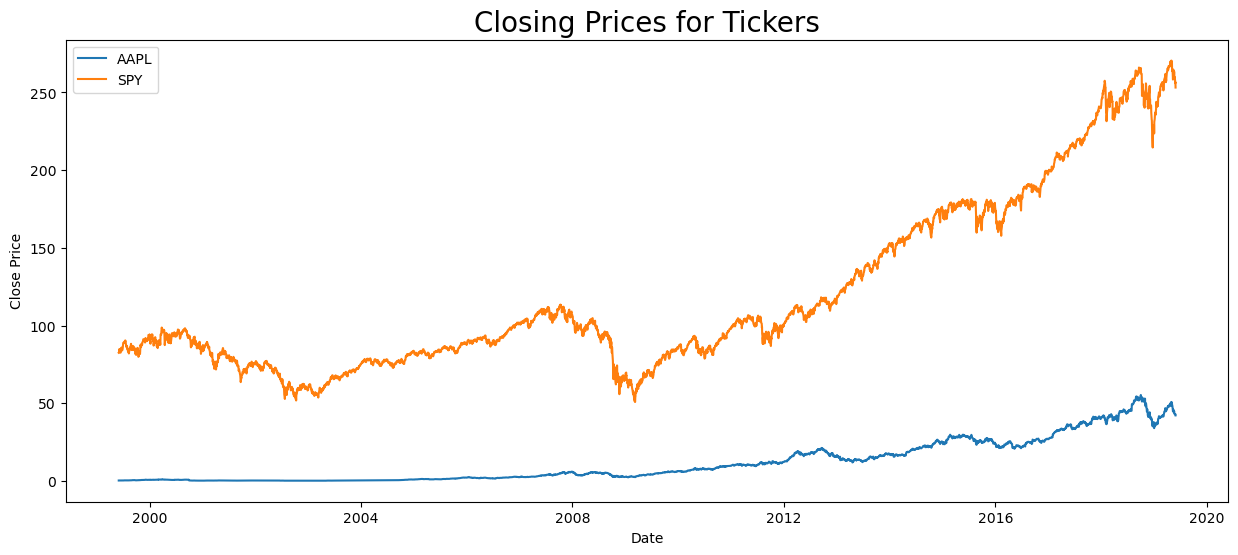

In [115]:

def dateparse(d):
    return pd.Timestamp(d)

fig = plt.figure(figsize=(15,6))
plt.title('Closing Prices for Tickers', fontsize=20)
for ticker in data.columns:
    plt.plot(data.index, data[ticker], label=ticker)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
# confirm data loaded

## Preprocess data
 For more details see [preprocess.ipynb](./preprocess.ipynb)

In [160]:
selected_ticker = "SPY"
df = data[selected_ticker]

class Loader32(Dataset):
    
    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)

# returns = df.shift(1)/df - 1
# log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
# standardScaler1 = StandardScaler()
# standardScaler2 = StandardScaler()
# gaussianize = Gaussianize()
# log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
# receptive_field_size = 127  # p. 17
# data_size = log_returns.shape[0]


def preprocess_log_returns(df, receptive_field_size=127):
    """
    Converts price data into log returns

    Args:
        df (pd.DataFrame): DataFrame containing the price data.
        receptive_field_size (int): Receptive field size parameter. Defaults to 127.

    Returns:
        tuple: A tuple containing the preprocessed log returns and the data size.
    """
    returns = df.shift(1) / df
    log_returns = np.log(returns)[1:].to_numpy().reshape(-1, 1)
    
    standardScaler1 = StandardScaler()
    standardScaler2 = StandardScaler()
    gaussianize = Gaussianize()
    
    log_returns_preprocessed = standardScaler2.fit_transform(
        gaussianize.fit_transform(
            standardScaler1.fit_transform(log_returns)
        )
    )
    
    data_size = log_returns.shape[0]
    
    return log_returns_preprocessed, data_size

log_returns_preprocessed, data_size = preprocess_log_returns(df)

print(log_returns_preprocessed.shape)
print(data_size)

(5032, 1)
5032


## Train model
 For more details see [torch_model.ipynb](./torch_model.ipynb)

In [117]:
import importlib
from model import torch_tcn
importlib.reload(torch_tcn)
from model.torch_tcn import Generator, Discriminator

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev) 


In [123]:
#naming
num_epochs = 200
version = 1

#noise
nz = 3
batch_size = 80
seq_len = 252
clip= 0.01


#learning rates
lr_discriminator = 0.001
lr_generator = 0.0002



In [124]:
import torch.optim as optim
from tqdm import tqdm
generator = Generator().to(device)

train = True
generator_loss = []
discriminator_loss = []

if train:
    discriminator = Discriminator(seq_len).to(device)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.001)
    gen_optimizer = optim.RMSprop(generator.parameters(), lr=0.0002)

    dataset = Loader32(log_returns_preprocessed, seq_len)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    t = tqdm(range(num_epochs))
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):

            discriminator.zero_grad()
            real = data.to(device)
            noise = torch.randn(80, 3, seq_len, device=device) #batch_size, nz, seq_len, device=device
            fake = generator(noise).detach()
            disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
            disc_loss.backward()
            disc_optimizer.step()
            discriminator_loss.append(disc_loss)

            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)
    
            # if idx % 5 == 0:
            generator.zero_grad()
            gen_loss = -torch.mean(discriminator(generator(noise)))
            gen_loss.backward()
            gen_optimizer.step()
            generator_loss.append(gen_loss)            
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
            
    # Save
    torch.save(generator, f'trained/trained_generator_{ticker}_daily_epoch_{epoch}_v{version}.pth')

else:
    # Load
    generator = torch.load(f'trained/trained_generator_SP500_daily_epoch_99.pth', map_location=torch.device('cpu'))
    generator.eval()

Discriminator Loss: -0.00000006 Generator Loss: -0.50342047: 100%|██████████| 200/200 [6:31:37<00:00, 117.49s/it]  


## Generate

In [144]:
generator.eval()
noise = torch.randn(80,3,250).to(device)
y = generator(noise).cpu().detach().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
# y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

80

## Results and visualizing stylized facts

Text(0, 0.5, 'Cumulative log return')

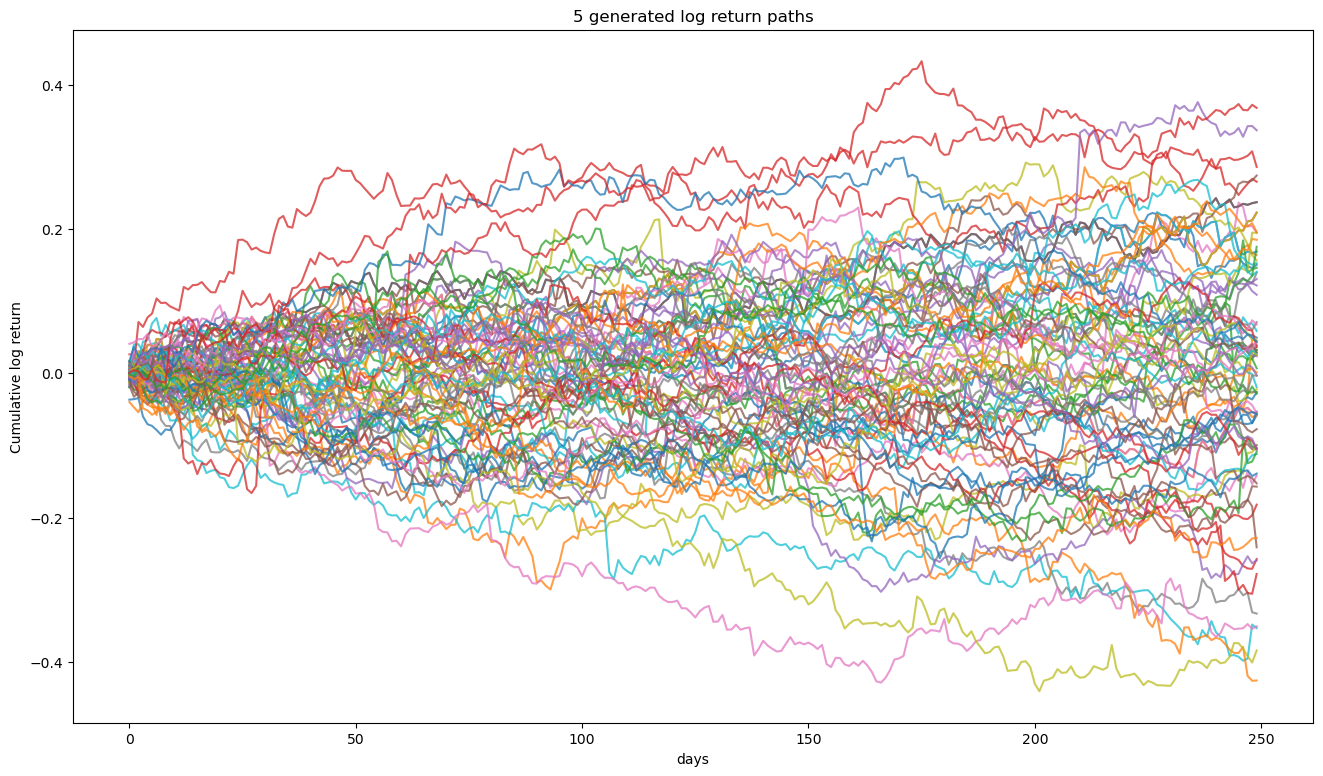

In [202]:
index = 20
n_paths = 5
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[index:index + n_paths], axis=1).T, alpha=0.75)
ax.plot(np.cumsum(y[0:80], axis=1).T, alpha=0.75)
ax.set_title(f'{n_paths} generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumulative log return')

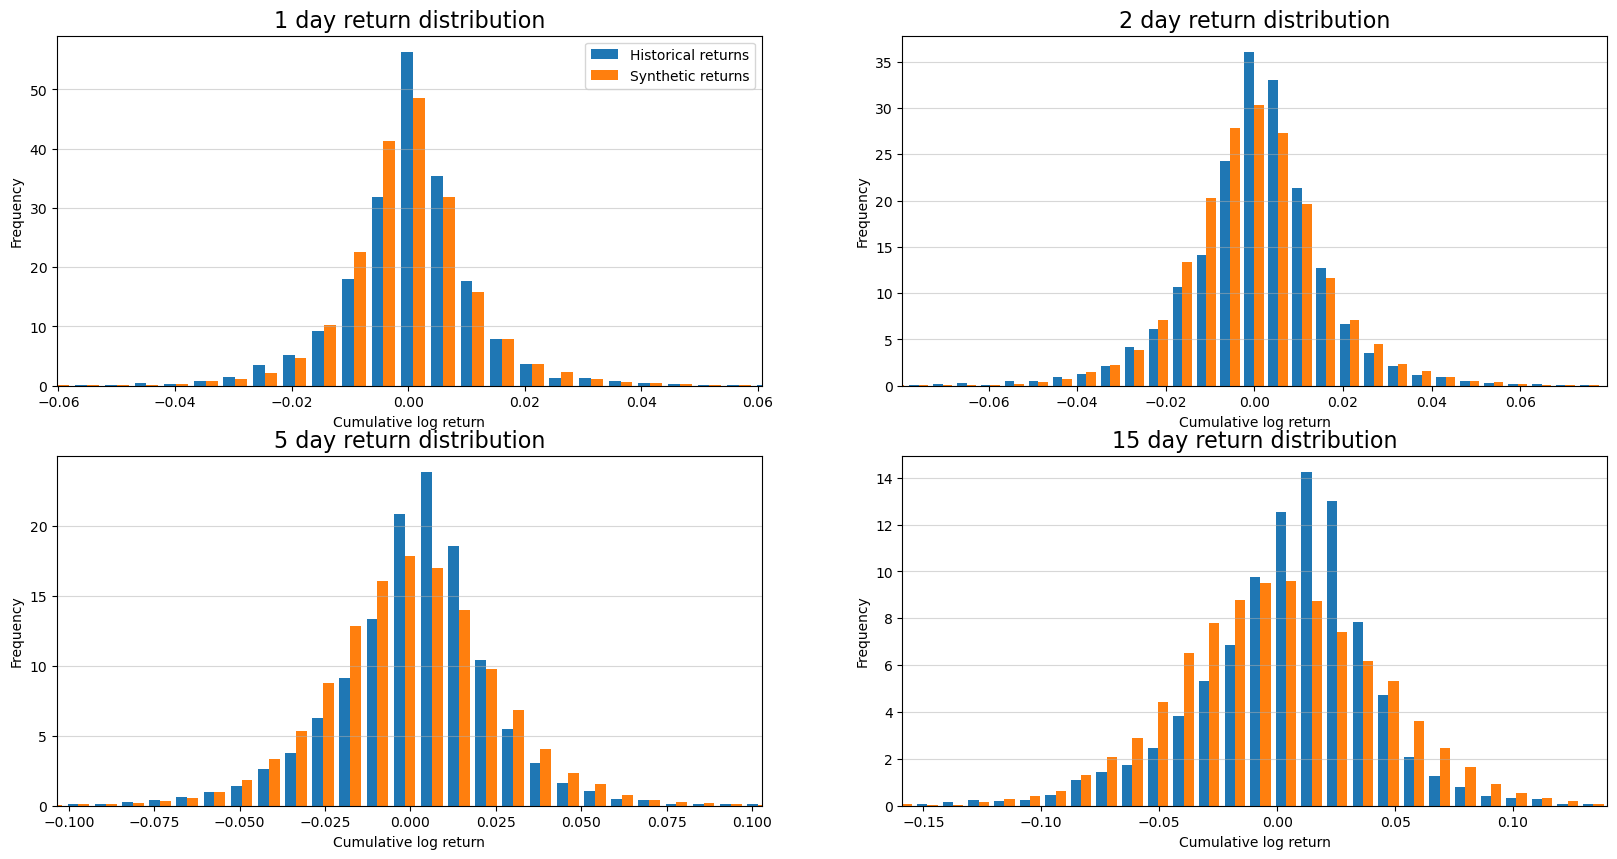

In [205]:
n_bins = 50
windows = [1,2,5,15]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumulative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

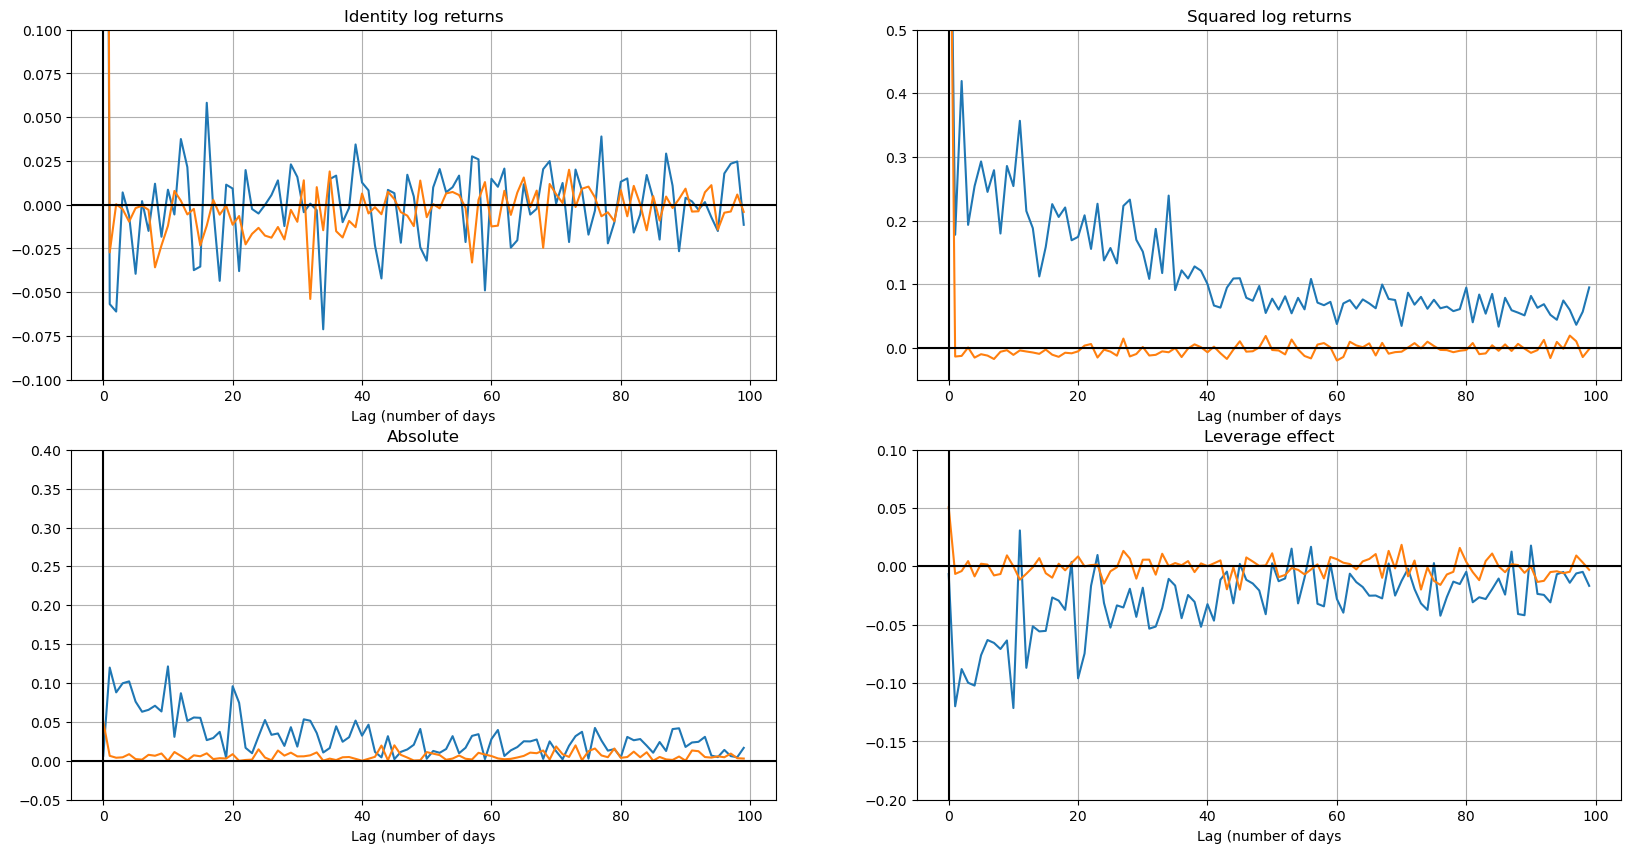

In [129]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')

In [203]:
def acf_cum_calculator(real_data, synth_data, time_period_cum):
    synth_acf = []
    real_acf = []
    for i in range(1,time_period_cum):
        #computes acf for real data over rolling window i
        real_acf_i = acf(real_data, i)
        real_acf.append(np.nanmean(real_acf_i))

        #computes acf for synthetic data over rolling window i
        acf_synth_i = acf(synth_data, i)
        synth_acf.append(np.nanmean(acf_synth_i))

    return np.mean(real_acf), np.mean(synth_acf)


real_acf, synth_acf = acf_cum_calculator(y, log_returns_preprocessed, 80)
print(f'Real acf: {real_acf:.3f} \nSynthetic acf: {synth_acf:.3f}')


Real acf: 0.055 
Synthetic acf: 0.057


In [201]:
import scipy as sp
from scipy.stats import kurtosis, skew
skew_synth = np.mean(sp.stats.skew(y, axis=0))
skew_real = np.mean(sp.stats.skew(log_returns_preprocessed, axis=0))

kurtosis_synth = np.mean(sp.stats.kurtosis(y, axis=0))
kurtosis_real = np.mean(sp.stats.kurtosis(log_returns_preprocessed, axis=0))


print(f'Kurtosis Synthetic: {kurtosis_synth:.3f}\nKurtosis Real: {kurtosis_real:.3f}\n\n')
print(f'Skew Synthetic: {skew_synth:.3f}\nSkew Real: {skew_real:.3f}')


Kurtosis Synthetic: 4.661
Kurtosis Real: -0.001


Skew Synthetic: 0.181
Skew Real: 0.125
